# 데이터 불러오기

In [4]:
!cp "/content/drive/MyDrive/Colab Notebooks/data/img_align_celeba.zip" "."
!unzip "./img_align_celeba.zip" -d "./GAN/"

Archive:  ./img_align_celeba.zip
warning [./img_align_celeba.zip]:  76 extra bytes at beginning or within zipfile
  (attempting to process anyway)
error [./img_align_celeba.zip]:  reported length of central directory is
  -76 bytes too long (Atari STZip zipfile?  J.H.Holm ZIPSPLIT 1.1
  zipfile?).  Compensating...
replace ./GAN/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# 데이터 살펴보기

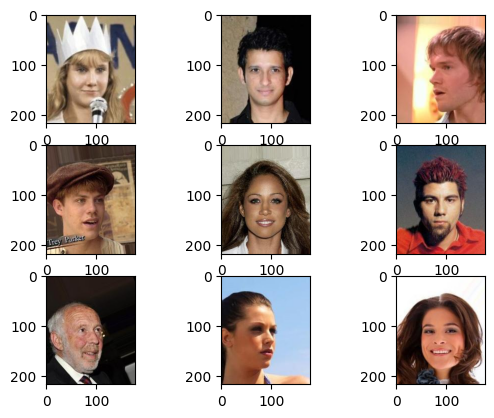

In [5]:
import glob
import matplotlib.pyplot as plt
import os

from PIL import Image

# 이미지까지의 경로
pth_to_imgs = "./GAN/img_align_celeba"
imgs = glob.glob(os.path.join(pth_to_imgs, "*"))


# 9개의 이미지를 보여줌
for i in range(9):
   plt.subplot(3, 3, i+1)
   img = Image.open(imgs[i])
   plt.imshow(img)

plt.show()

# 이미지 전처리 정의
- ImageFolder 객체가 이미지를 읽어오는 과정
1. 최상위 폴더 안에
2. 클래스별로 폴더를 만들고 그 안에 해당 클래스의
3. 이미지 파일을 모아둡니다.
ImageFolder()에 최상위 경로를 입력해주면 자동으로 클래스별 이미지를 읽어 파이토치의 Dataset 객체로 반환해줍니다.


In [6]:
import torch
import torchvision.transforms as tf

from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader

# 1. 이미지의 전처리 과정
transforms = tf.Compose([
   tf.Resize(64),
   tf.CenterCrop(64),
   tf.ToTensor(),
   tf.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 2. ImageFolder()를 이용해 데이터셋을 작성
# root는 최상위 경로를, transform은 전처리를 의미합니다.
dataset = ImageFolder(
    root = "./GAN",
    transform=transforms
)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

# 생성자 정의
- 업샘플링층과 배치 정규화층을 쌓아서 만들 수 있습니다.
- 입력은 100차원의 벡터로 하겠습니다.
- 차원 수는 특징 수 입니다.
- 적은 개수의 특징을 이용하면 학습은 쉬워지지만 성능이 낮아집니다.

In [7]:
import torch.nn as nn

class Generator(nn.Module):
   def __init__(self):
       super(Generator, self).__init__()

       # 생성자를 구성하는 층 정의
       self.gen = nn.Sequential(
           nn.ConvTranspose2d(100, 512, kernel_size=4, bias=False),
           nn.BatchNorm2d(512),
           nn.ReLU(),

           nn.ConvTranspose2d(512, 256, kernel_size=4,
                              stride=2, padding=1, bias=False),
           nn.BatchNorm2d(256),
           nn.ReLU(),

           nn.ConvTranspose2d(256, 128, kernel_size=4,
                              stride=2, padding=1, bias=False),
           nn.BatchNorm2d(128),
           nn.ReLU(),

           nn.ConvTranspose2d(128, 64, kernel_size=4,
                              stride=2, padding=1, bias=False),
           nn.BatchNorm2d(64),
           nn.ReLU(),

           nn.ConvTranspose2d(64, 3, kernel_size=4,
                              stride=2, padding=1, bias=False),
           nn.Tanh()
       )
       # 생성자의 마지막 층은 각 픽셀은 값을 결정하는 층이기 때문에 배치 정규화를 사용하지 않습니다.
       # 마지막 층에 Tanh() 함수를 사용한 이유는
       # Tanh() 함수가 원점에 대해 대칭적이기 때문입니다.

   def forward(self, x):
       return self.gen(x)

# 감별자 정의
- 감별자의 마지막 층에서는 이미지가 진짜인지 가짜인지를 판별하는 이진 분류층이 됩니다.
- 따라서 활성화 함수도 시그모이드 함수를 사용합니다.

In [8]:
class Discriminator(nn.Module):
   def __init__(self):
       super(Discriminator, self).__init__()

       # 감별자를 구성하는 층의 정의
       self.disc = nn.Sequential(
           nn.Conv2d(3, 64, kernel_size=4,
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(64),
           nn.LeakyReLU(0.2),
           # LeakyReLU(slope)
           # LeakyReLU 함수를 계산해 반환합니다.
           # 0보다 작은 범위에서 slope 기울기를 갖습니다.

           nn.Conv2d(64, 128, kernel_size=4,
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(128),
           nn.LeakyReLU(0.2),

           nn.Conv2d(128, 256, kernel_size=4,
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(256),
           nn.LeakyReLU(0.2),

           nn.Conv2d(256, 512, kernel_size=4,
                     stride=2, padding=1, bias=False),
           nn.BatchNorm2d(512),
           nn.LeakyReLU(0.2),

           nn.Conv2d(512, 1, kernel_size=4),
           nn.Sigmoid()
       )

   def forward(self, x):
       return self.disc(x)

# GAN의 가중치 초기화 함수

In [10]:
def weights_init(m):
   # 층의 종류 추출
   classname = m.__class__.__name__
   if classname.find('Conv') != -1:
       # 합성곱층 초기화
       # nn.init.normal_(data, mean, std)
       # 함수는 정규분포를 따라 가중치를 초기화 합니다.
       # 가중치 data, 평균 mean, 표준편차 std를 갖는 정규분포에서 랜덤하게 설정합니다.
       nn.init.normal_(m.weight.data, 0.0, 0.02)
   elif classname.find('BatchNorm') != -1:
       # 배치정규화층 초기화
       nn.init.normal_(m.weight.data, 1.0, 0.02)
       nn.init.constant_(m.bias.data, 0)
       # nn.init.constant_(data, val)
       # 가중치 data를 val로 설정합니다.

# 학습에 필요한 요소 정의
1. 진짜 이미지 한 배치와
2. 생성자가 생성한 가짜 이미지 한 배치를 학습합니다.한 번 학습된 감별자는 감별 능력이 완벽하진 않지만 조금 개선됩니다.
3. 생성자가 만들어낸 이미지를 감별자가 진짜라고 판단하도록 가중치의 업데이트가 일어납니다.

위 과정을 여러 번 반복하면서 GAN 의 학습이 이루어지게 됩니다.

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# 생성자 정의
G = Generator().to(device)
# ❶ 생성자 가중치 초기화
G.apply(weights_init)

# 감별자 정의
D = Discriminator().to(device)
# ❷ 감별자 가중치 초기화
D.apply(weights_init)

import tqdm

from torch.optim.adam import Adam

G_optim = Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
D_optim = Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

# 학습 루프 정의

In [ ]:
for epochs in range(50):
   iterator = tqdm.tqdm(enumerate(loader, 0), total=len(loader))

   for i, data in iterator:
       D_optim.zero_grad()

       # ➊ 실제 이미지에는 1, 생성된 이미지는 0으로 정답을 설정
       label = torch.ones_like(
           data[1], dtype=torch.float32).to(device)
       label_fake = torch.zeros_like(
           data[1], dtype=torch.float32).to(device)

       # ➋ 실제 이미지를 감별자에 입력
       real = D(data[0].to(device))

       # ❸ 실제 이미지에 대한 감별자의 오차를 계산
       Dloss_real = nn.BCELoss()(torch.squeeze(real), label)
       Dloss_real.backward()
       # ➊ 가짜 이미지 생성
       noise = torch.randn(label.shape[0], 100, 1, 1, device=device)
       fake = G(noise)

       # 가짜 이미지를 감별자에 입력
       output = D(fake.detach())

       # 가짜 이미지에 대한 감별자의 오차를 계산
       Dloss_fake = nn.BCELoss()(torch.squeeze(output), label_fake)
       Dloss_fake.backward()

       # ➋ 감별자의 전체 오차를 학습
       Dloss = Dloss_real + Dloss_fake
       D_optim.step()
       # ➊ 생성자의 학습
       G_optim.zero_grad()
       output = D(fake)
       Gloss = nn.BCELoss()(torch.squeeze(output), label)
       Gloss.backward()

       G_optim.step()

       iterator.set_description(f"epoch:{epochs} iteration:{i} D_loss:{Dloss} G_loss:{Gloss}")

torch.save(G.state_dict(), "Generator.pth")
torch.save(D.state_dict(), "Discriminator.pth")

epoch:0 iteration:258 D_loss:0.017772646620869637 G_loss:8.679645538330078:  16%|█▋        | 259/1583 [36:42<3:25:25,  9.31s/it]

In [ ]:
with torch.no_grad():
   G.load_state_dict(
       torch.load("./Generator.pth", map_location=device))

   # 특징 공간 상의 랜덤한 하나의 점을 지정
   feature_vector = torch.randn(1, 100, 1, 1).to(device)
   # 이미지 생성
   pred = G(feature_vector).squeeze()
   pred = pred.permute(1, 2, 0).cpu().numpy()

   plt.imshow(pred)
   plt.title("predicted image")
   plt.show()